# Transmission Profile Processing

This notebook processes the data collected in the measurement notebook to produce Signal-to-Noise plots and the final transmission profile of the sapphire coating sample.

Sam Condon \
Caltech \
05/18/2021

In [2]:
from Support_Functions import *

## Preprocessing

#### Get metadata for all measurements

In [3]:
with open('metadata.json') as f:
    data = json.load(f)
MetaData = np.array(data['measurements']) 
Types = np.array([m['type'] for m in MetaData]) #create array of all measurement types
Lockins = np.array([m['lock-in'] for m in MetaData])
Attenuators = np.array([str(m['attenuators']) for m in MetaData])
FileNames = np.array([m['file-name'] for m in MetaData])
SampleTimes = np.array([m['sample-time'] for m in MetaData])
LightSources = np.array([m['light-source'] for m in MetaData])
Wavelengths = np.array([m['monochromator']['wavelength'] for m in MetaData])
Wavelengths[np.where(Wavelengths == None)] = 0.0

#### Create a dictionary for desired signal measurement(s) w/o attenuation from ThorLab source

In [6]:
##Get desired measurement metadata

##Define masks
sig_filename = None #only used if one individual measurement is desired
type_mask = np.where(Types == 'signal') #get only signal measurements
atten_mask = np.intersect1d(np.where(Attenuators == 'None'), type_mask) #no attenuators
date_mask = np.intersect1d(np.where(np.char.find(FileNames, '05-28') != -1), atten_mask)
#wavelength_mask = np.where(Wavelengths > 0.7)
mask_final = date_mask

if sig_filename is not None:
    mask_final = np.where(FileNames == sig_filename)

final_meta = MetaData[mask_final]
SigNoAttenWaves = [m['monochromator']['wavelength'] for m in final_meta]    
    
SigNoAttenDf = create_df(MetaData, mask_final)
print(SigNoAttenWaves)

[0.7, 0.75, 1.22, 1.79, 2.17, 2.64, 3.11, 3.58, 4.05, 4.53, 5.0]


#### Signal w/o attenuation from Advanced Illumination Source

In [17]:
filename = None

source_mask = np.where(LightSources == 'ai sl2420')
atten_mask = np.where(Attenuators == 'None')
sample_time_mask = np.where(SampleTimes > 1000)
mask = np.intersect1d(sample_time_mask, atten_mask)
mask_final = np.intersect1d(source_mask, mask)

if filename is not None:
    mask_final = np.where(FileNames == filename)

final_meta = MetaData[mask_final]
    
SigNoAttenShortWaveDf = create_df(MetaData, mask_final)
SigNoAttenShortWaves = [m['monochromator']['wavelength'] for m in final_meta]
print(SigNoAttenShortWaves)

[0.66, 0.66, 0.66, 0.66]


#### Create dictionary for desired signal measurement(s) w/ attenuation

In [14]:
sig_filename = None #only used if one individual measurement is desired
type_mask = np.where(Types == 'signal') #get only signal measurements
atten_mask = np.intersect1d(np.where(np.char.find(Attenuators, 'sapphire') != -1), type_mask) #no attenuators
date_mask = np.intersect1d(np.where(np.char.find(FileNames, '05-28') != -1), atten_mask)
wavelength_mask = np.where(Wavelengths > 0.7)
mask_final = np.intersect1d(date_mask, wavelength_mask)

if sig_filename != None:
    mask_final = np.where(FileNames == sig_filename)
    
final_meta = MetaData[mask_final]    
SigAttenWaves = [m['monochromator']['wavelength'] for m in final_meta]
print(SigAttenWaves)

SigAttenDf = create_df(MetaData, mask_final)


[0.75, 1.22, 1.79, 2.17, 2.64, 3.11, 3.58, 4.05, 4.53, 5.0]


#### Signal w/ attenuation from Advanced Illumination Source

In [15]:
source_mask = np.where(LightSources == 'ai sl2420')
atten_mask = np.where(np.char.find(Attenuators, 'sapphire') != -1)
sample_time_mask = np.where(SampleTimes > 1000)
mask = np.intersect1d(sample_time_mask, atten_mask)
mask_final = np.intersect1d(source_mask, mask)

final_meta = MetaData[mask_final]

SigAttenShortWaveDf = create_df(MetaData, mask_final)
SigAttenShortWaves = [m['monochromator']['wavelength'] for m in final_meta]
print(SigAttenShortWaves)

[0.66, 0.66]


#### Create a dictionary for desired noise measurement(s)

In [7]:
noise_filename = 'data\\2021-05-27_0.csv' #used to isolate a single noise
type_mask = np.where(Types == 'detector noise')

if noise_filename is not None:
    mask_final = np.where(FileNames == noise_filename)
else:
    mask_final = type_mask

##Create data-frame used for noise power analysis
NoiseDf = create_df(MetaData, mask_final)
NoiseTypes = np.unique(NoiseDf['Type'])

#remove mean from noise voltages
NoiseDf['Voltage'] = NoiseDf['Voltage'].values - NoiseDf['Voltage'].values.mean() 

## Signal to Noise Computations

#### Noise time series and fft

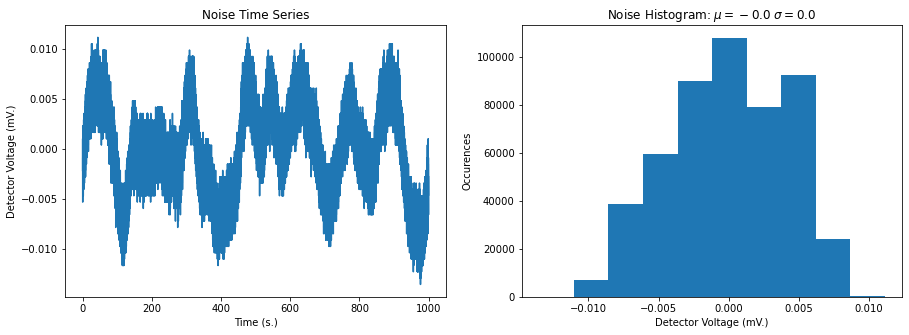

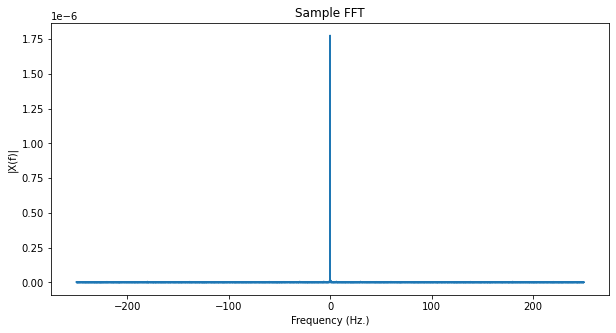

In [9]:
%matplotlib inline
int_t = np.linspace(1, 2000, 100)
plot_time_hist(NoiseDf['Time'], NoiseDf['Voltage'], plot_title='Noise')
NoiseFs = 1/(NoiseDf['Time'][1] - NoiseDf['Time'][0])
NoiseFFT = fft(NoiseDf['Voltage'].values, NoiseFs, plot=True)


#### Signal time series and fft

C:\Users\thoma\Studies\SPHEREx\SW-Dev\SPHEREx-lab-tools\SPHEREx-Calibration-Automation\notebooks\Sapphire Window Coating Measurements\Support_Functions.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, plts = plt.subplots(1,2, figsize=(15,5))


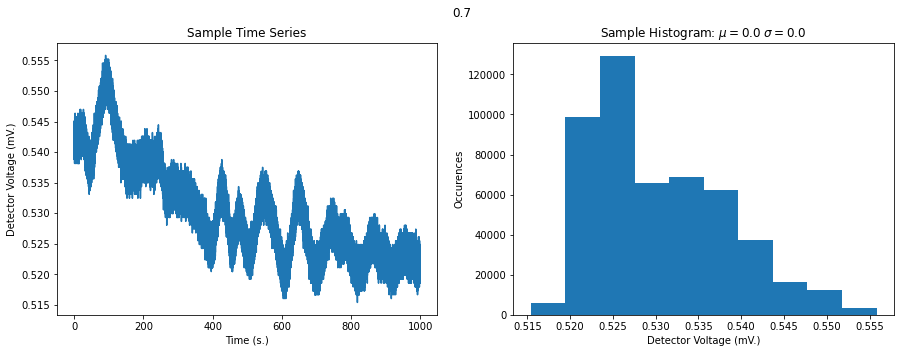

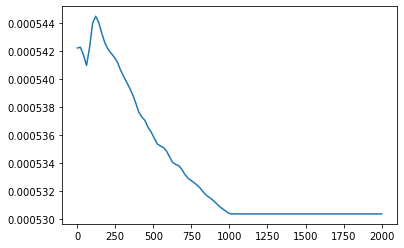

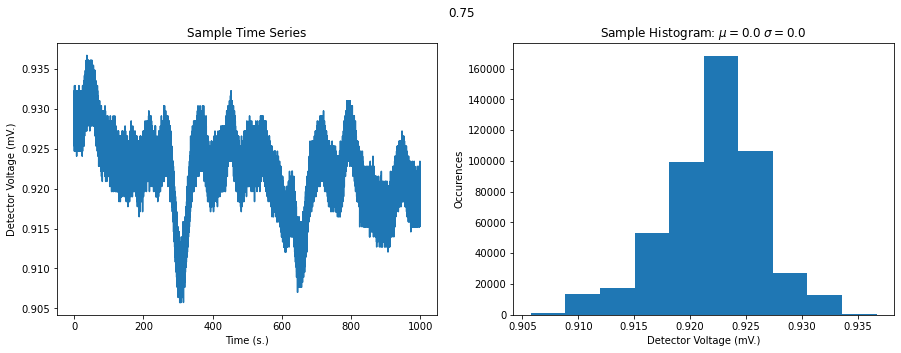

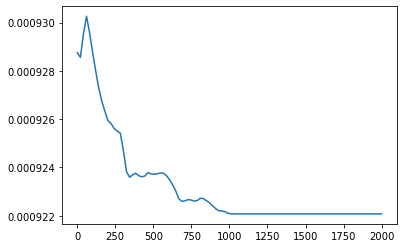

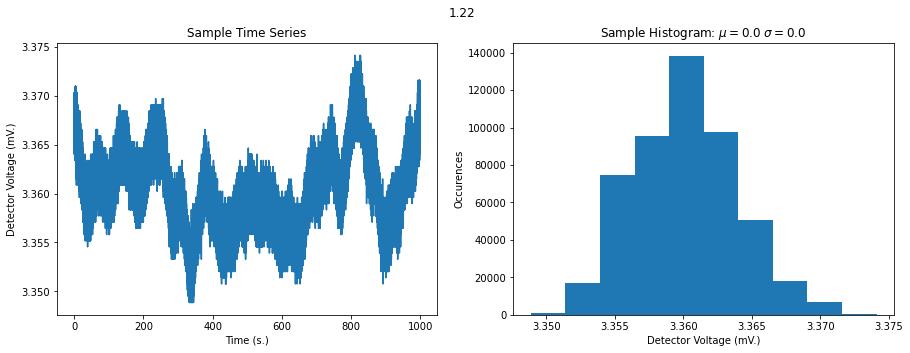

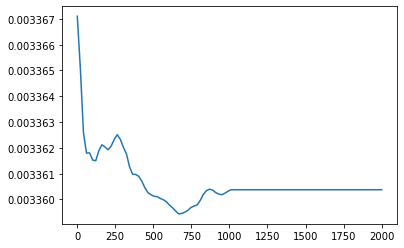

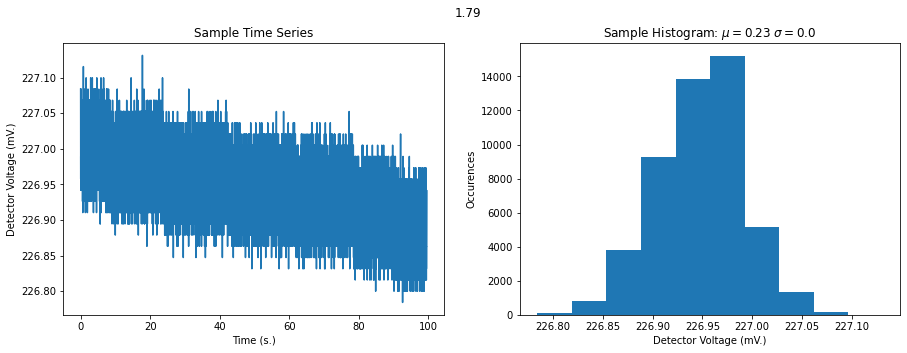

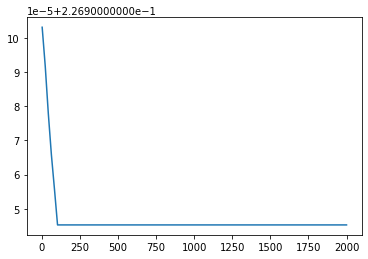

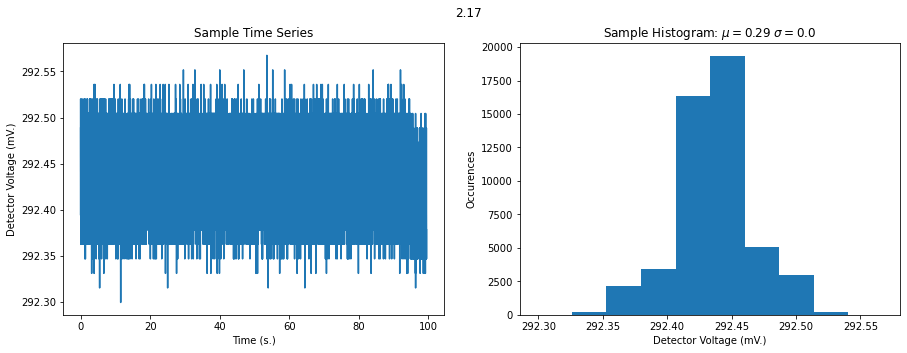

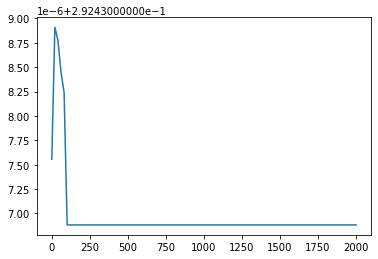

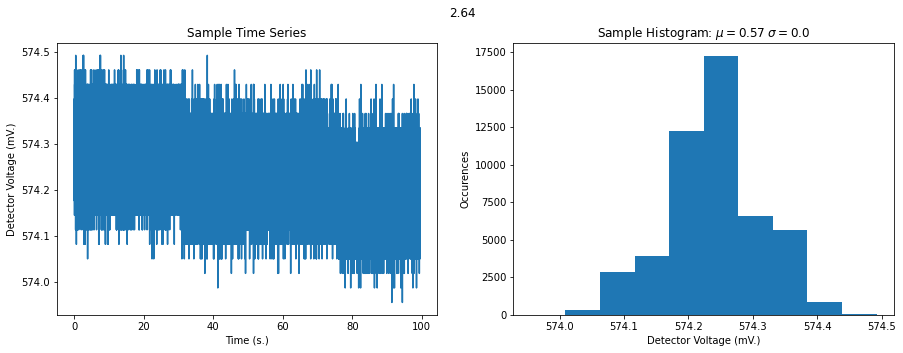

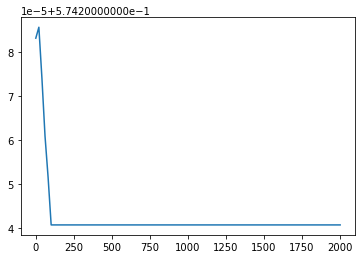

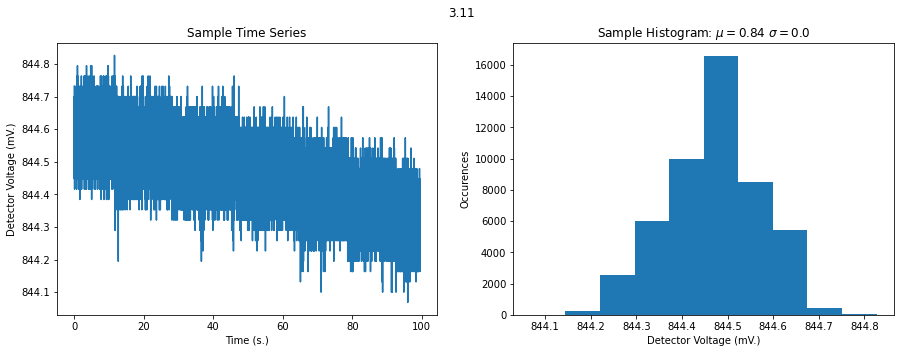

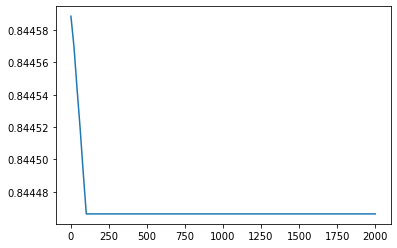

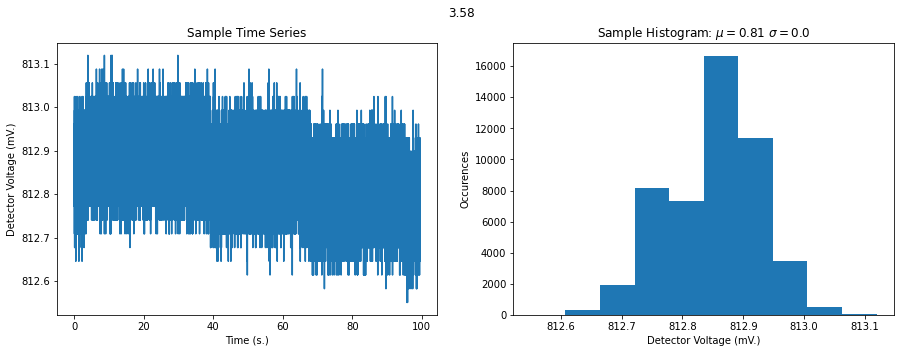

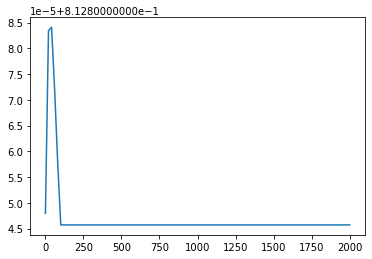

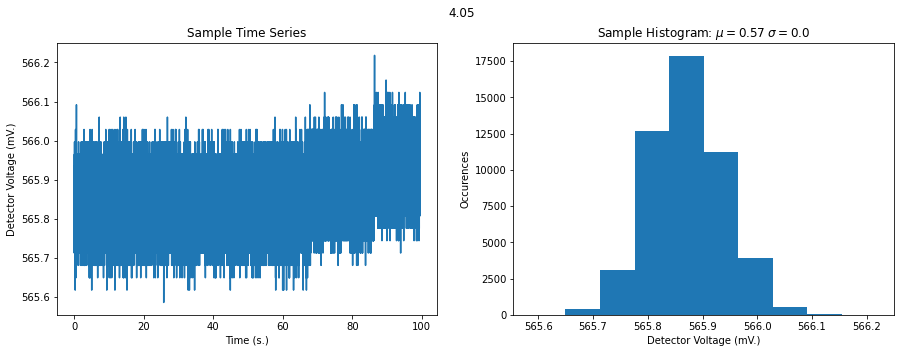

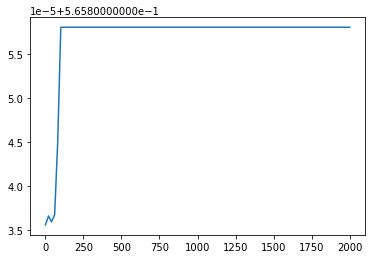

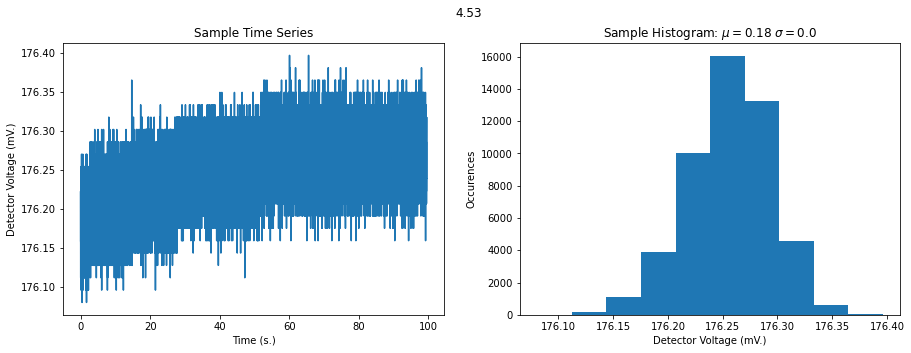

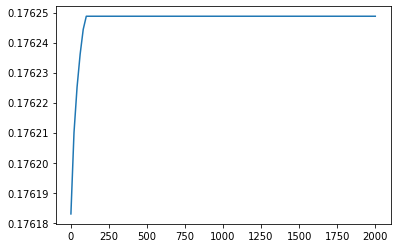

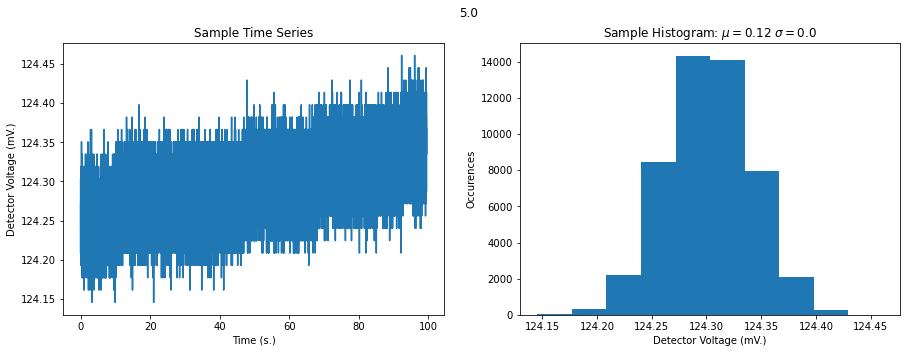

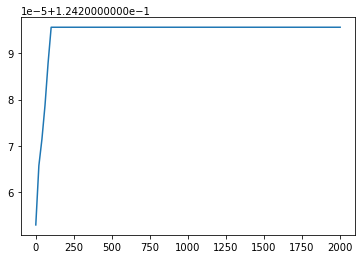

In [12]:
##THORLABS SOURCE###################################################

%matplotlib inline
int_t = np.linspace(1, 2000, 100)
multiple_ts_fft(SigNoAttenDf, np.unique(SigNoAttenWaves), int_t=int_t)

In [ ]:
##ADVANCED ILLUMINATION SOURCE########################################

int_t = np.linspace(1, 2000, 100)
multiple_ts_fft(SigNoAttenShortWaveDf, np.unique(SigNoAttenShortWaves), int_t)

In [ ]:
%matplotlib inline
int_t = np.linspace(1, 2000, 100)
multiple_ts_fft(SigAttenDf, SigAttenWaves, int_t=int_t)

In [ ]:
SigAttenDf['Voltage'].mean()

In [ ]:
int_t = np.linspace(1, 2000, 100)
multiple_ts_fft(SigAttenShortWaveDf, np.unique(SigAttenShortWaves), int_t)

#### Rms noise power as function of integration time

In [ ]:
%matplotlib inline
IntT = np.linspace(0.01, 1000, 100)
NoisePowersRms = np.zeros(len(IntT))
ind = 0
for t in IntT:
    NoisePowersRms[ind] = fft_rms_power_calc(NoiseFFT['fft_mags'], NoiseFFT['freqs'], t)
    ind += 1

#print(NoisePowersRms)
plt.plot(IntT, NoisePowersRms)

## SNR as Function of Wavelength for all Sources Used

Wavelengths: 
[0.7, 0.75, 1.22, 1.79, 2.17, 2.64, 3.11, 3.58, 4.05, 4.53, 5.0]
SNRs:
[2.58457327e+05 4.49320168e+05 1.63748801e+06 1.10588807e+08
 1.42502380e+08 2.79823327e+08 4.11502318e+08 3.96093836e+08
 2.75738561e+08 8.58847670e+07 6.05683449e+07]


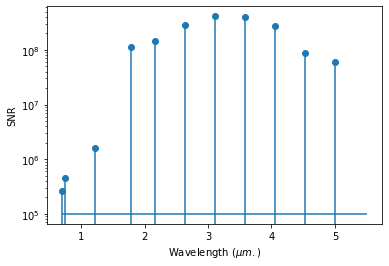

In [11]:
%matplotlib inline
sig_noatten_powers = np.zeros(len(SigNoAttenWaves))
ind = 0
for w in SigNoAttenWaves:
    df = SigNoAttenDf[SigNoAttenDf['Type'].isin([w])]
    fs = 1/(df['Time'].values[1] - df['Time'].values[0])
    
    voltages = df['Voltage'].values
                 #   - NoiseDf['Voltage'].values #voltages w/ noise removed
    #compute signal voltage
    sig_noatten_powers[ind] = voltages.mean()
    ind += 1

    
#plt.plot(SigWaves, sig_noatten_powers)

rms_noise_power = fft_rms_power_calc(NoiseFFT['fft_mags'], NoiseFFT['freqs'], int_t=1000)
snr_curve = sig_noatten_powers / rms_noise_power

print('Wavelengths: ')
print(SigNoAttenWaves)
print('SNRs:')
print(snr_curve)
plt.stem(SigNoAttenWaves, snr_curve)
plt.xlabel(r'Wavelength ($\mu m.$)')
plt.hlines(1e5, xmin=0.7, xmax=5.5)
plt.ylabel('SNR')
plt.yscale('log')

## Required Integration time as function of wavelength for a given SNR

In [ ]:
SNR = 1e6
int_t = np.linspace(1, 2000, 100)
int_t_inds = np.ones(len(SigNoAttenWaves))*False

i0 = 0
for w in SigNoAttenWaves:
    sig_voltages = SigNoAttenDf[SigNoAttenDf['Type'].isin([w])]['Voltage']
    sig = sig_voltages.mean()
    i1 = 0
    for t in int_t:
        if sig/fft_rms_power_calc(NoiseFFT['fft_mags'], NoiseFFT['freqs'], int_t=t) >= SNR:
            int_t_inds[i0] = i1
            break
        i1 += 1
    i0 += 1
    
print(int_t_inds)

## Transmission Profile

Text(0.5, 0, 'Wavelength $\\mu$m.')

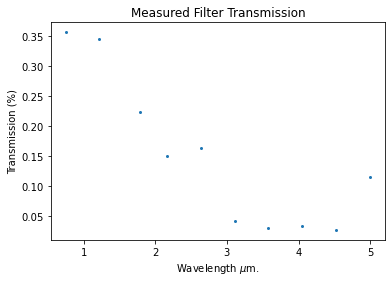

In [18]:
transmissions = np.zeros(len(SigAttenWaves))
ind = 0
for w in SigAttenWaves:
    voltages = SigNoAttenDf[SigNoAttenDf['Type'].isin([w])]['Voltage']
    atten_voltages = SigAttenDf[SigAttenDf['Type'].isin([w])]['Voltage']
    transmissions[ind] = atten_voltages.mean() / voltages.mean()
    ind += 1

#convert to percentage
transmissions *= 1e2 

plt.scatter(SigAttenWaves, transmissions, s=4)
plt.title('Measured Filter Transmission')
plt.ylabel('Transmission (%)')
plt.xlabel(r'Wavelength $\mu$m.')

Text(0.5, 0, 'Wavelength $\\mu$m.')

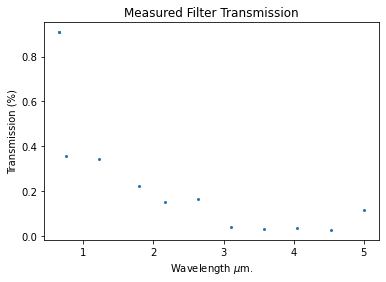

In [19]:
waves = np.append(SigAttenShortWaves, SigAttenWaves)
transmissions = np.zeros(len(waves))
ind = 0
for w in SigAttenShortWaves:
    voltages = SigNoAttenShortWaveDf[SigNoAttenShortWaveDf['Type'].isin([w])]['Voltage']
    atten_voltages = SigAttenShortWaveDf[SigAttenShortWaveDf['Type'].isin([w])]['Voltage']
    transmissions[ind] = atten_voltages.mean() / voltages.mean()
    ind += 1
    
for w in SigAttenWaves:
    voltages = SigNoAttenDf[SigNoAttenDf['Type'].isin([w])]['Voltage']
    atten_voltages = SigAttenDf[SigAttenDf['Type'].isin([w])]['Voltage']
    transmissions[ind] = atten_voltages.mean() / voltages.mean()
    ind += 1

transmissions *= 1e2
    
plt.scatter(waves, transmissions, s=4)
plt.title('Measured Filter Transmission')
plt.ylabel('Transmission (%)')
plt.xlabel(r'Wavelength $\mu$m.')

In [ ]:
print(waves)

In [ ]:
print(transmissions)

## Verifications

#### Verification of fft routine

In [ ]:
fs = 30
t = np.arange(-1, 1, 1/fs)
f = 2
test_sig = 3 + 3*np.sin(2*np.pi*f*t) + 2*np.cos(2*2*f*np.pi*t)
ts_fft = fft(test_sig, fs)

#### Verification of fft_power_calc

In [ ]:
int_t = 100

#Generate moving average filter corresponding to given integration time and perform filtering in time
ma_N = int(int_t*NoiseFs)
ma_filter = (1/ma_N)*np.ones(ma_N)
noise_integrated = np.convolve(ma_filter, NoiseDf['Voltage'].values)
nf_power = fft_rms_power_calc(NoiseFFT['fft_mags'], NoiseFFT['freqs'], int_t=int_t)

print(np.sqrt((noise_integrated**2).mean()))
print(nf_power)




In [ ]:
np.sqrt((NoiseDf['Voltage'].values**2).mean())

In [ ]:
fft_rms_power_calc(NoiseFFT['fft_mags'], NoiseFFT['freqs'])

#### Verification of rms noise power vs integration time

In [ ]:
%matplotlib inline
IntT = [800]
NoisePowersRmsFft = np.zeros(len(IntT))
NoisePowersRmsMa = np.zeros(len(IntT))
ind = 0
for t in IntT:
    #Generate moving average filter corresponding to given integration time and perform filtering in time
    ma_N = int(t*NoiseFs)
    ma_filter = (1/ma_N)*np.ones(ma_N)
    noise_integrated = np.convolve(ma_filter, NoiseDf['Voltage'].values)
    NoisePowersRmsMa[ind] = np.sqrt((noise_integrated**2).mean())
    NoisePowersRmsFft[ind] = fft_rms_power_calc(NoiseFFT['fft_mags'], NoiseFFT['freqs'], t)
    ind += 1


In [ ]:
print(NoisePowersRmsFft)
print(NoisePowersRmsMa)

In [ ]:
%matplotlib qt
fig, ax = plt.subplots()

ax.plot(IntT, NoisePowersRmsFft, label='FFT based')
ax.plot(IntT, NoisePowersRmsMa, label='Box-car')
ax.legend(fontsize=40)